In [2]:
import os 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Data Compilation
We run through directories and create the dataframes for the behavioral and eye movement data.

In [4]:
def params_to_code(x):
    return "%s_%s_%s"%(x.fileCode,x.viewing,x.trialCounter)
# data_dir="C:\\Users\\C-LAB\\projects\\crowding_freeviewing\\results\\PilotData\\MOCS"
data_dir="Z:\\projects\\crowding freeviewing\PilotData\PilotData\MOCS"
behavData=[]
for afolder in os.listdir(data_dir):
    os.chdir(os.path.join(data_dir,afolder))
    for afile in os.listdir(os.getcwd()):
        if afile.endswith('.csv'): # behav data file
            try:
                tempData=pd.read_csv(os.path.join(afile))
                #Add subject ID
                tempData['subj']=afolder
                if 'fixation' in afile:
                    tempData['viewing']='fixation'
                elif 'freeViewing' in afile:
                    tempData['viewing']='freeViewing'
                tempData['trialCounter']=np.arange(1,len(tempData)+1)
                tempData['fileCode']=afile[0:afile.find('_f')]
                behavData.append(tempData)
            except:
                pass
behavData=pd.concat(behavData)
behavData["code"]=(behavData.apply(params_to_code,1)).astype(str)
behavData=behavData.drop('fileCode',axis=1)
behavData['target']=np.abs(behavData['target'])

In [3]:
def PixelConversion(horz_res,vert_res,diagonal_size,dist_to_screen):
    #Pixel Calculations: Shows the pixel to degree conversion

    diagonal_pixel=np.sqrt(((horz_res)**2)+((vert_res)**2))
    pixel_per_cm=diagonal_pixel/diagonal_size
    
    # Visual angle calculation: We use the above info to calculate number of pixels
    #that fall in a degree of visual angle
    cm_per_degree=dist_to_screen*np.pi/180
    pixels_per_degree= cm_per_degree * pixel_per_cm
    
    return pixels_per_degree,pixel_per_cm,cm_per_degree
#We enter the monitor parameters here and calculate pixels per cm
horz_res=3840
vert_res=2160
diagonal_size=68.58 #diagonal screen size
dist_to_screen= 45 #cm
#we then get the pixel conversion value
pixel_per_degree,pixel_per_cm,cm_per_degree=PixelConversion(horz_res,vert_res,diagonal_size,dist_to_screen)

In [4]:
#calculating BCEA (68% confidence ellispe)
def CalcBCEA(xdata,ydata):
    rho=np.corrcoef( xdata, ydata)[0,1]
    bcea= 2.291 * np.pi * np.std(xdata) * np.std(ydata) * np.sqrt(1-rho**2)
    return bcea

data_dir="Z:\\projects\\crowding freeviewing\\PilotData\\PilotData\\MOCS"
eyepos_df=[]
bcea_list=[]
code_list=[]
for afolder in os.listdir(data_dir):
    os.chdir(os.path.join(data_dir,afolder))
    for afile in os.listdir(os.getcwd()):
        if afile.endswith('.asc'): # Eye movt file
            # We first read in the data from the raw eye movement
            # file
            eyepos_file=open(afile,'rt')
            data=eyepos_file.readlines()
            trialCounter=1
            # We loop through each line and only use sameples that are relavant
            # and those that occur between TrialStart and TrialEnd messages
            for lineIdx in range(len(data)):
                if 'TrialStart' in data[lineIdx]:
                    startIdx=lineIdx+1
                elif 'TrialEnd' in data[lineIdx]:
                    stopIdx=lineIdx-1
                    tempData=data[startIdx:stopIdx]
                    filtData=[]
                    for aline in tempData:
                        if 'SFIX' in aline:
                            continue
                        elif 'SSACC'  in aline:
                            continue
                        elif 'SBLINK' in aline:
                            continue
                        elif 'EFIX' in aline:
                            continue
                        elif 'ESACC' in aline:
                            continue
                        elif 'EBLINK' in aline:
                            continue
                        elif '.	   .' in aline: #blink/eye tracking lost
                            continue
                        elif 'StimulusOnset' in aline:
                            #TO DO get stimulus time
                            continue
                        else:
                            filtData.append(aline)
                    # After we clean up the data we write it up back out to csv
                    outputFilename=afile[0:afile.find('.csv')-12]+'_'+str(trialCounter)+'.csv'
                    with open(outputFilename,'w') as file:
                        file.writelines(filtData)
                    # Read in the filtered eye pos data file
                    try:
                        tempData=pd.read_csv(outputFilename,delimiter='\t',header=None)
                        trialCode=outputFilename[0:outputFilename.find('.csv')] # Unique trial Code
                        tempData['code']=trialCode
                        tempData['subj']=afolder # Subj ID
                        # Format columns
                        tempData.columns=['time','xposRaw','yposRaw','pupilSize','Setting1','Setting2','code','subj']
                        # Convert xpos and ypos to degrees
                        tempData['xpos']=(tempData['xposRaw']-tempData['xposRaw'].iloc[0])/pixel_per_degree
                        tempData['ypos']=(tempData['yposRaw']-tempData['yposRaw'].iloc[0])/pixel_per_degree
                        # Compute BCEA for each trial individually
                        bcea=CalcBCEA(tempData['xpos'],tempData['ypos'])
                        bcea_list.append(bcea)
                        code_list.append(trialCode)
                        #Remove the temporary file for each trial after reading it into the df
                        os.remove(outputFilename)
                        eyepos_df.append(tempData)
                    except:
                        pass
                    trialCounter+=1
bcea_df=pd.DataFrame(np.column_stack((bcea_list,code_list)))
bcea_df.columns=['bcea','code']
bcea_df['bcea']=bcea_df['bcea'].astype(float)
merged_df=pd.merge(bcea_df,behavData,left_on='code',right_on='code')
eyepos_df=pd.concat(eyepos_df)

NameError: name 'behavData' is not defined

In [7]:
temp_df=eyepos_df.query("code=='S01_S1_T001_ecc_8_freeViewing_1'")
temp_df.to_csv("sampleData.csv")

## Behavioral data analysis

In [21]:
eyepos_df.columns

Index(['time', 'xpos', 'ypos', 'pupilSize', 'Setting1', 'Setting2', 'code',
       'subj'],
      dtype='object')

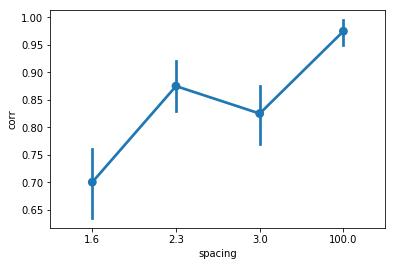

In [8]:
sns.pointplot(x='spacing',y='corr',data=behavData)#.query("subj=='S02'"))

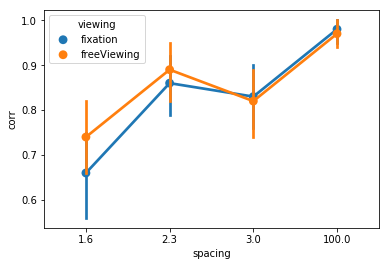

In [9]:
sns.pointplot(x='spacing',y='corr',data=behavData.query("subj=='S01'"),hue='viewing')

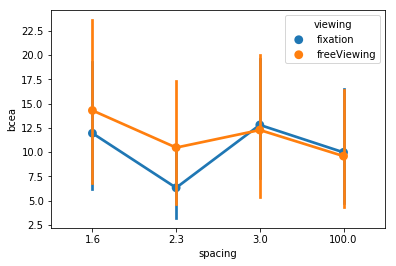

In [16]:
sns.pointplot(x='spacing',y='bcea',data=merged_df,hue='viewing')